# Plotting SASA Values
## By Joe Laforet Jr.
### This notebook reads in all SASA values in the current folder and displays them on an interactive graph. Note, the labels are generated by hand and need to be updated each time a new combination is added.

In [2]:
import os
import glob

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import plotly.graph_objects as go

from rdkit import Chem
from rdkit.Chem import rdFreeSASA
from rdkit.Chem import AllChem
from rdkit.Chem.rdMolDescriptors import CalcMolFormula

from collections import defaultdict

In [3]:
all_data = glob.glob("SASA*.dat")
all_data

['SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_Budesonide_100_168_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_Budesonide_100_168_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_Budesonide_100_168_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_CandesartanCilexetil_100_146_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_CandesartanCilexetil_100_146_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_CandesartanCilexetil_100_146_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_Indomethacin_100_202_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_Indomethacin_100_202_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_Indomethacin_100_202_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_TannicAcid_100_95_run1.dat',
 'SASA_DATA_openmm_NPT_25

### Change Below Labels to 

## Using matplotlib and displaying error bars

In [4]:
def get_Controls(data):
    
    control_vols = {}
    for x in data:
        if x.split("_")[11] == '0':
            drug = x.split("_")[8]
            
            max_SASA = pd.read_csv(x, header = None).max()[0]
            
            control_vols[drug] = max_SASA
            
    return control_vols

In [5]:
norms = get_Controls(all_data)
norms

{'Atovaquone': 12414.9912109375,
 'Fulvestrant': 18800.7890625,
 'Lumefantrine': 15847.421875,
 'Rilpivirine': 13801.3984375,
 'Sorafenib': 15538.830078125}

In [44]:
def make_SASAplots(data, labels, norms, binary = False):
    #data is an array of filepaths to .csv's of RDF data
    #this function will plot all of the input .csv's on the same graph
    
    fig, ax = plt.subplots()
    fig.set_size_inches(30, 20)
    
    j=0
    
    out_data = []
    
    linestyles = ['solid', 'dotted', 'dashed', 'dashdot', (0, (1, 3))]
    for i in range(len(data)//3):
        #tempDF1 = pd.read_csv(data[j], header = None, engine = 'python')
        #tempDF2 = pd.read_csv(data[j+1], header = None, engine = 'python')
        #tempDF3 = pd.read_csv(data[j+2], header = None, engine = 'python')
        
        tempDFs = [pd.read_csv(data[j], header=None, engine='python'),
                   pd.read_csv(data[j+1], header=None, engine='python'),
                   pd.read_csv(data[j+2], header=None, engine='python')]

        present_files = [x for x, df in enumerate(tempDFs) if len(df) == 100]
        
        if(len(present_files) == 0):
            present_files.append(max(range(len(tempDFs)), key=lambda i: len(tempDFs[i])))
        #print(present_files)
        mean = np.zeros(len(tempDFs[present_files[0]]))
        std_dev = 0
        if len(present_files) == 2:
            print("two")
            mean = np.mean([tempDFs[present_files[0]][0], tempDFs[present_files[1]][0]], axis=0)
            std_dev = np.std([tempDFs[present_files[0]][0], tempDFs[present_files[1]][0]], axis=0)
            #std_dev = 0
        elif len(present_files) == 3:
            mean = np.mean([tempDFs[0][0], tempDFs[1][0], tempDFs[2][0]], axis=0)
            std_dev = np.std(np.mean([tempDFs[0][0], tempDFs[1][0], tempDFs[2][0]], axis=0))
        elif len(present_files) == 1:
            print("one!")
            mean = tempDFs[present_files[0]][0]
            std_dev = np.std(tempDFs[present_files[0]][0])
        
        if labels[i] == '(+)':
            colorb = 'orange'
            linestyle = 'solid'
        else:
            colorb = 'blue'
            linestyle = 'dashed' 

        #name = labels[i] + '-' + data[j].split("_")[9]
        name = data[j].split("_")[9]

        norm = norms.get(data[j].split("_")[8])
        #norm=1
        
        mean_plus_std = 100*(mean + std_dev) / norm
        mean_minus_std = 100*(mean - std_dev) / norm
        
        x = np.arange(len(mean))*.25
        
        #ax1 = plt.subplot(121)
        #plt.plot(x, mean / norm,
         #       label = name,
         #       linestyle = linestyle)
                    
        #plt.fill_between(x ,mean_plus_std, mean_minus_std, alpha = 0.1)

        #ax2 = plt.subplot(122)
        out_data.append(100*mean/norm)
        ax.plot(x, (100*mean / norm),
                label = name,
                linestyle = linestyles[i],
                linewidth=4.5,
                 color = colorb)
                    
        ax.fill_between(x ,mean_plus_std, mean_minus_std, alpha = 0.1, color = colorb)
        # Iterate over each curve
            # Get the last x and y values for the curve
        last_x = x[-1]
        last_y = (100*mean[-1])/norm

        # Display the label as text to the right of the last datapoint of the curve
        ax.text(last_x + 0.1, last_y, f"{name}", ha='left', va='center')
        j= j + 3
        #print(mean)
    drug = data[0].split("_")[8]
    excip = data[0].split("_")[9]
    #ax1.legend(loc='best')
    #ax1.set_title(f"Avg SASA for {drug} Simulations (N=3)")
    #ax1.set_xlabel('Time (ns)')
    #ax1.set_ylabel('Drug SASA % ($\AA^2$)')
    
    #ax2.legend(loc='best')
    #ax2.set_title(f"Avg SASA for {drug} Simulations (N=3)")
    #ax2.set_xlabel('Time (ns)')
    #ax2.set_ylabel('Drug SASA % ($\AA^2$)')
    
    #plt.legend()
    plt.title(f"Avg SASA for {drug} Simulations (N=3)")
    plt.xlabel('Time (ns)')
    plt.ylabel('Drug SASA %')
    
    #plt.grid()
    plt.tight_layout()
    plt.savefig(drug+'_SASA.svg', bbox_inches='tight')
    plt.show() 
    return out_data

In [7]:
import matplotlib
matplotlib.rcParams.update({'font.size': 45})

In [8]:
real_data = []
for x in all_data:
    if x.split("_")[11] != '0':
        real_data.append(x)
real_data

['SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_Budesonide_100_168_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_Budesonide_100_168_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_Budesonide_100_168_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_CandesartanCilexetil_100_146_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_CandesartanCilexetil_100_146_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_CandesartanCilexetil_100_146_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_Indomethacin_100_202_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_Indomethacin_100_202_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_Indomethacin_100_202_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_TannicAcid_100_95_run1.dat',
 'SASA_DATA_openmm_NPT_25

In [10]:
ATO = real_data[0:15]
ATO

['SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_Budesonide_100_168_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_Budesonide_100_168_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_Budesonide_100_168_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_CandesartanCilexetil_100_146_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_CandesartanCilexetil_100_146_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_CandesartanCilexetil_100_146_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_Indomethacin_100_202_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_Indomethacin_100_202_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_Indomethacin_100_202_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Atovaquone_TannicAcid_100_95_run1.dat',
 'SASA_DATA_openmm_NPT_25

In [11]:
FUV = real_data[15:30]
FUV

['SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Fulvestrant_Budesonide_100_226_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Fulvestrant_Budesonide_100_226_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Fulvestrant_Budesonide_100_226_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Fulvestrant_CandesartanCilexetil_100_195_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Fulvestrant_CandesartanCilexetil_100_195_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Fulvestrant_CandesartanCilexetil_100_195_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Fulvestrant_Indomethacin_100_273_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Fulvestrant_Indomethacin_100_273_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Fulvestrant_Indomethacin_100_273_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Fulvestrant_TannicAcid_100_124_run1.dat',
 'SASA_DATA_op

In [12]:
LUM = real_data[30:45]
LUM

['SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Lumefantrine_Budesonide_100_205_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Lumefantrine_Budesonide_100_205_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Lumefantrine_Budesonide_100_205_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Lumefantrine_CandesartanCilexetil_100_177_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Lumefantrine_CandesartanCilexetil_100_177_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Lumefantrine_CandesartanCilexetil_100_177_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Lumefantrine_Indomethacin_100_247_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Lumefantrine_Indomethacin_100_247_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Lumefantrine_Indomethacin_100_247_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Lumefantrine_TannicAcid_100_113_run1.dat',
 'SA

In [13]:
RIL = real_data[45:60]
RIL

['SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Rilpivirine_Budesonide_100_171_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Rilpivirine_Budesonide_100_171_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Rilpivirine_Budesonide_100_171_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Rilpivirine_CandesartanCilexetil_100_148_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Rilpivirine_CandesartanCilexetil_100_148_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Rilpivirine_CandesartanCilexetil_100_148_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Rilpivirine_Indomethacin_100_205_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Rilpivirine_Indomethacin_100_205_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Rilpivirine_Indomethacin_100_205_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Rilpivirine_TannicAcid_100_96_run1.dat',
 'SASA_DATA_ope

In [14]:
SOR = real_data[60:75]
SOR

['SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Sorafenib_Budesonide_100_176_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Sorafenib_Budesonide_100_176_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Sorafenib_Budesonide_100_176_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Sorafenib_CandesartanCilexetil_100_153_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Sorafenib_CandesartanCilexetil_100_153_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Sorafenib_CandesartanCilexetil_100_153_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Sorafenib_Indomethacin_100_212_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Sorafenib_Indomethacin_100_212_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Sorafenib_Indomethacin_100_212_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Sorafenib_TannicAcid_100_99_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMS

In [15]:
ATO_labels = ['(+)', '(-)', '(-)', '(-)', '(-)']
FUV_labels = ['(-)', '(+)', '(-)', '(+)', '(-)']
LAP_labels = ['(-)', '(-)', '(-)', '(-)', '(-)']
LUM_labels = ['(-)', '(+)', '(+)', '(-)', '(-)']
PTX_labels = ['(-)', '(+)', '(+)', '(-)', '(-)']
RIL_labels = ['(-)', '(+)', '(-)', '(-)', '(-)']
SOR_labels = ['(-)', '(+)', '(+)', '(+)', '(-)']

new_ATO_labels = ['(-)', '(+)', '(-)', '(-)', '(-)']
new_FUV_labels = ['(-)', '(+)', '(+)', '(+)', '(-)']

### Atovaquone

two


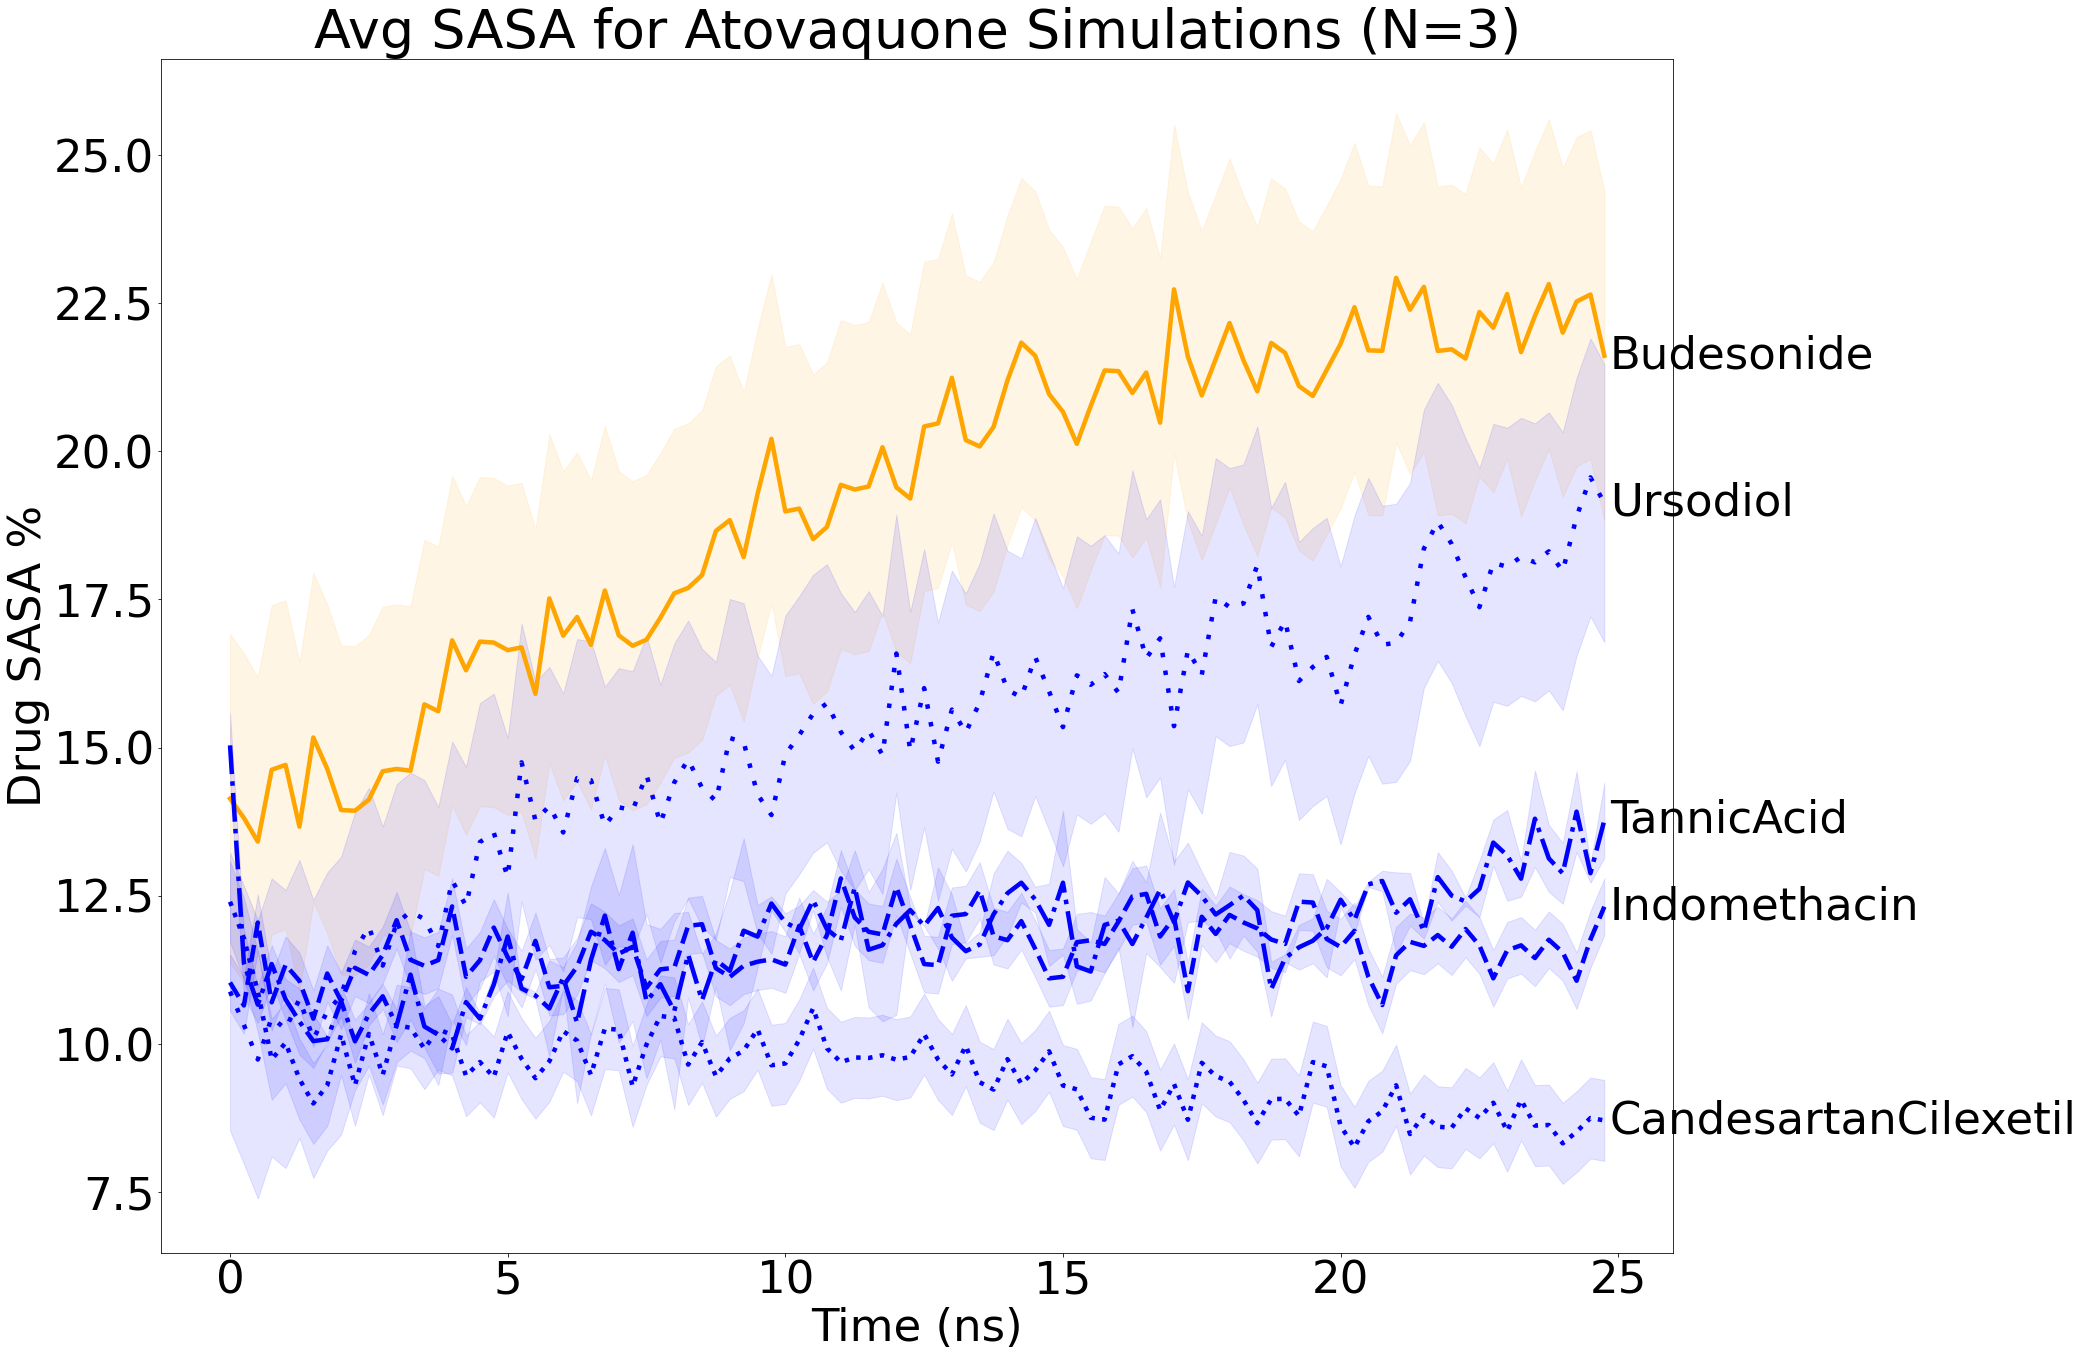

In [45]:
ato_sasa = make_SASAplots(ATO, ATO_labels, norms)

two


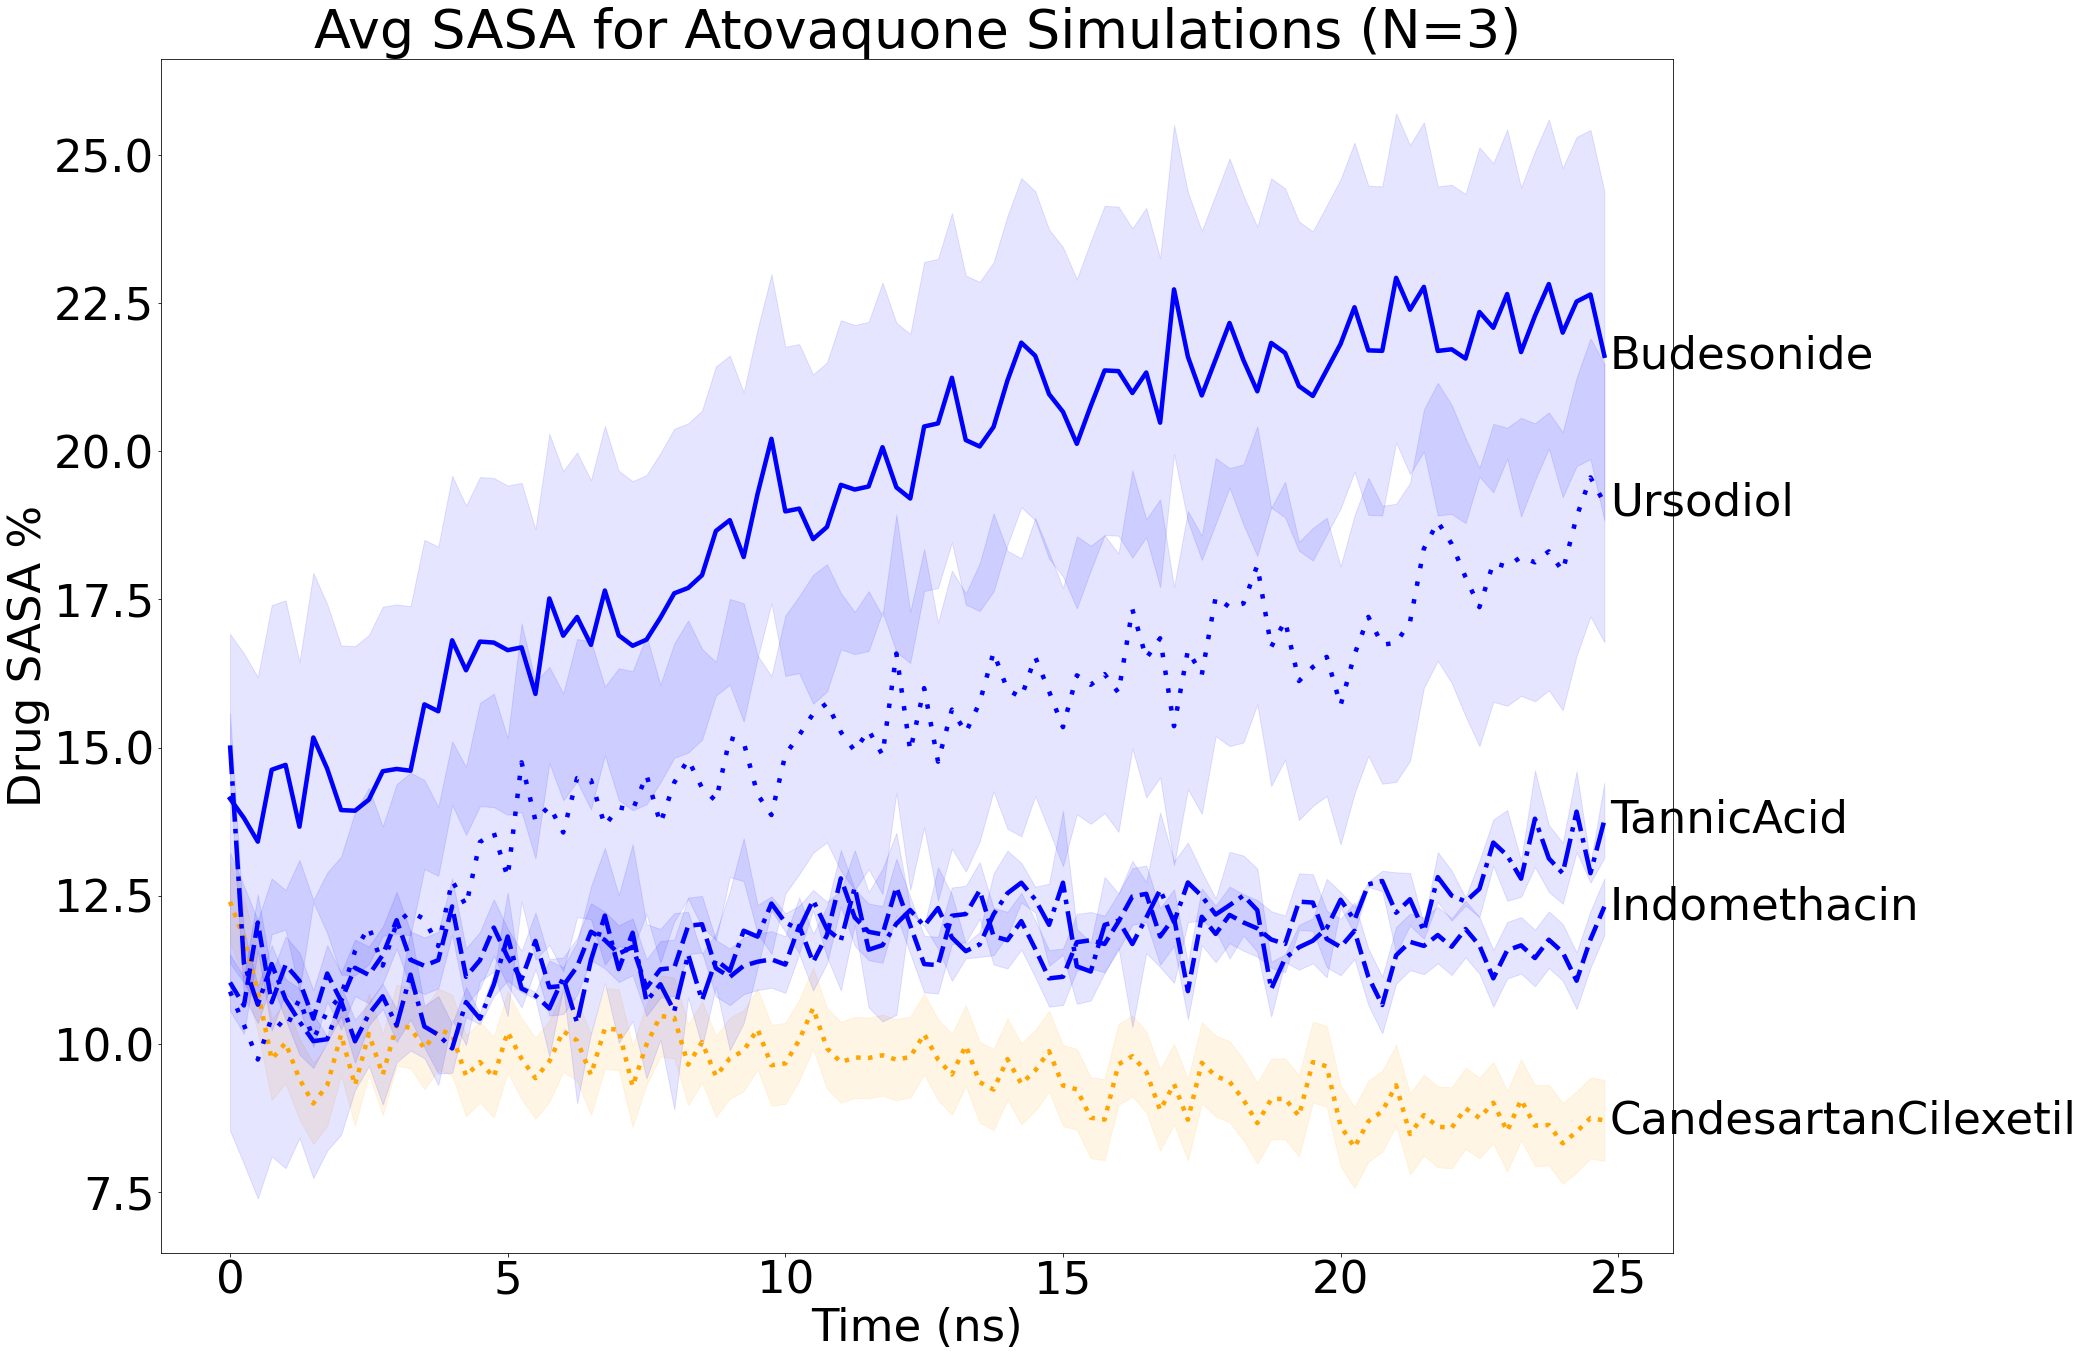

In [46]:
new_ato_sasa = make_SASAplots(ATO, new_ATO_labels, norms)

### Fulvestrant

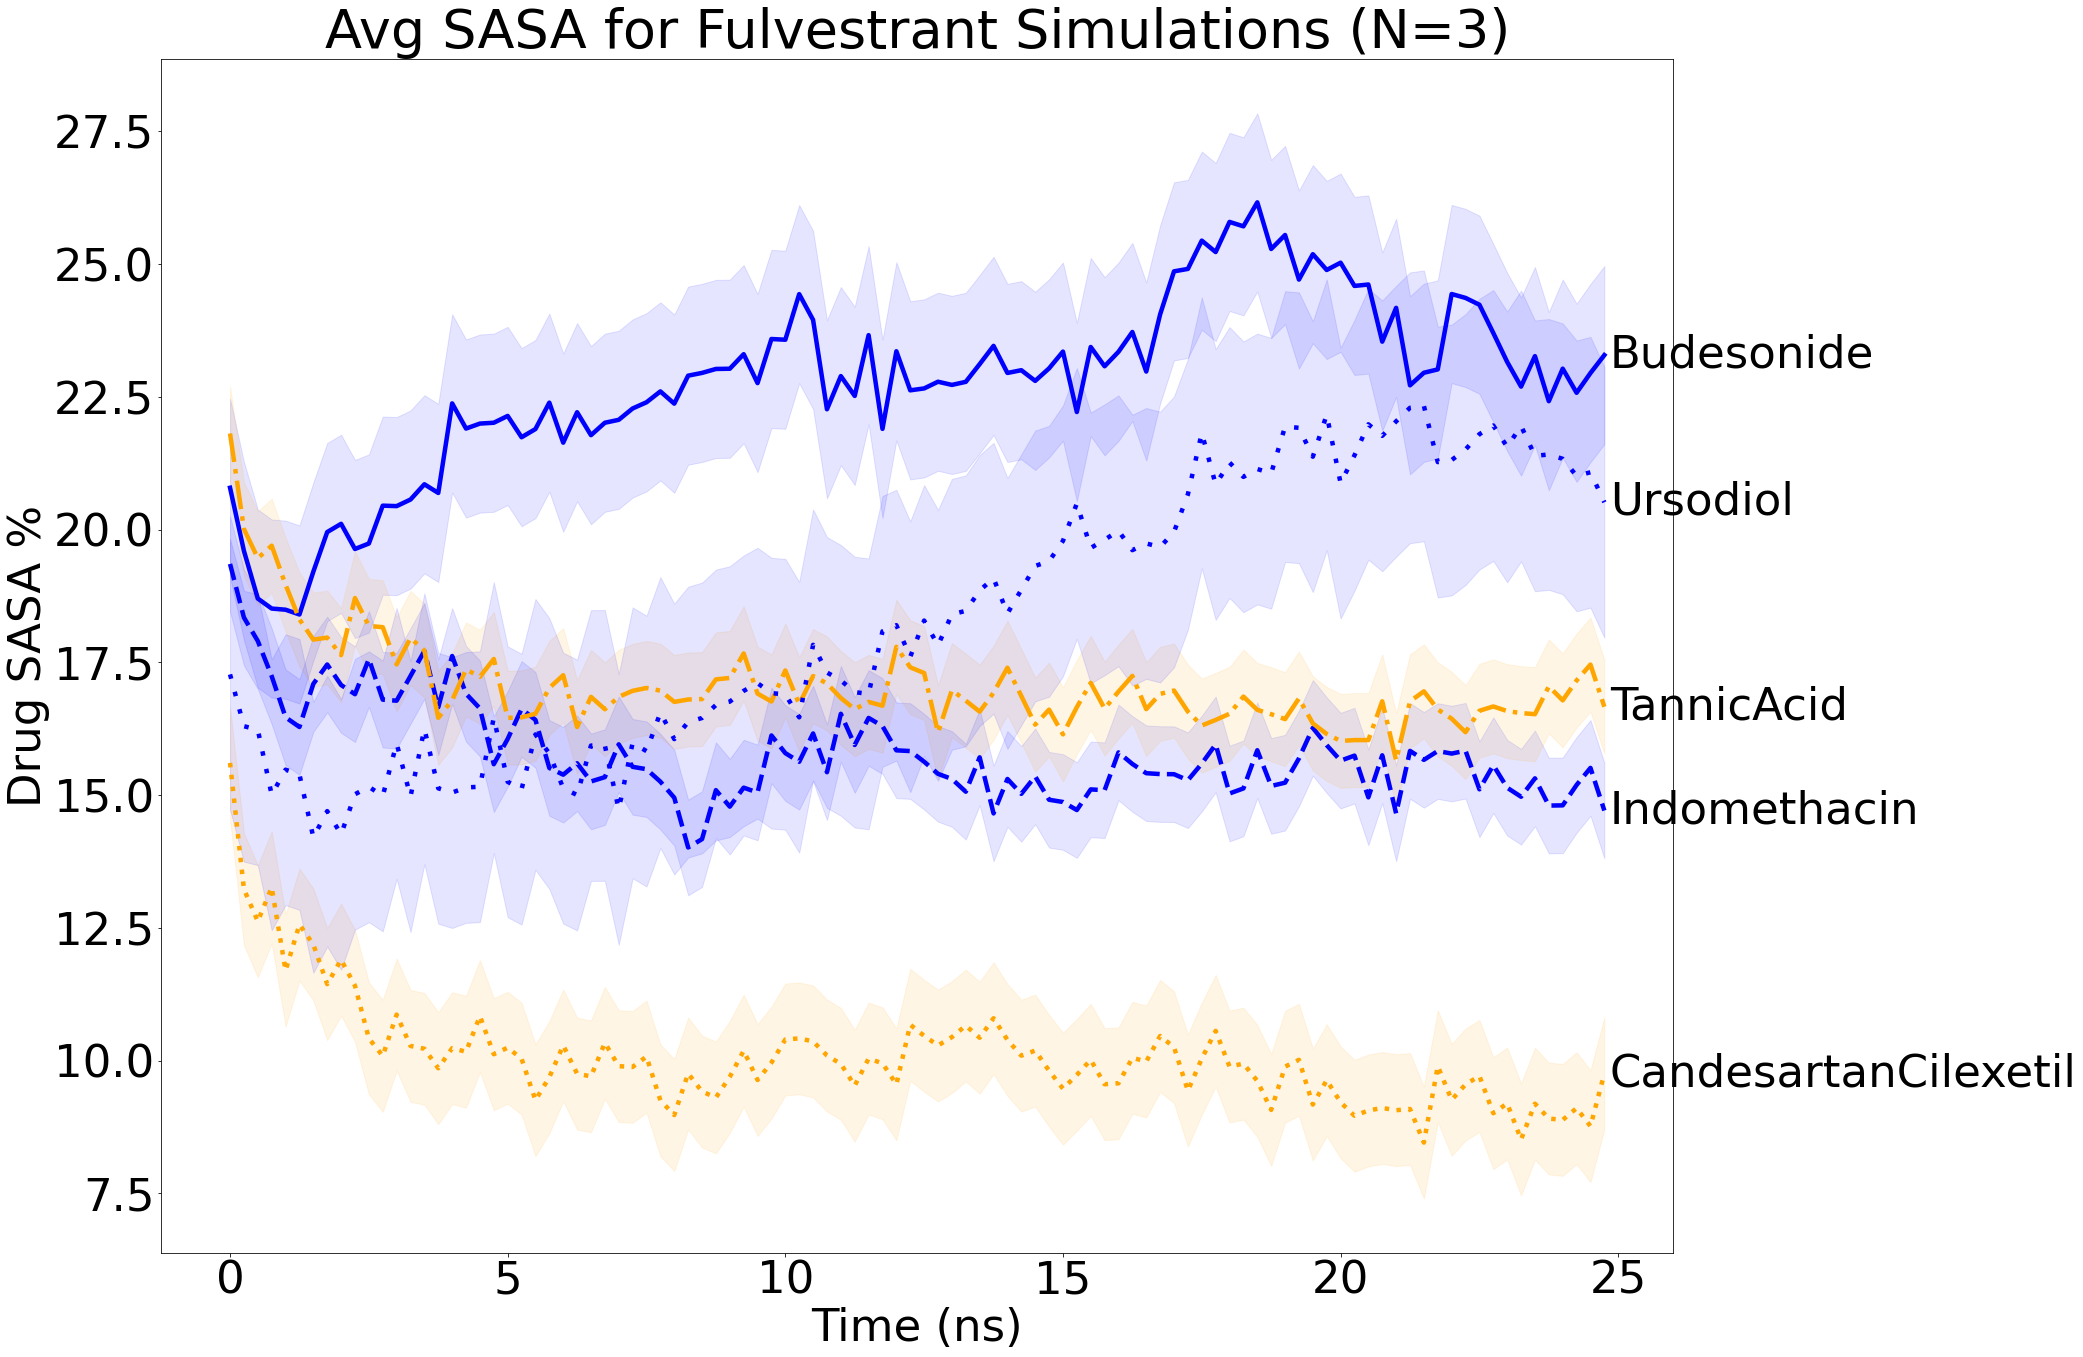

In [47]:
fuv_sasa = make_SASAplots(FUV, FUV_labels, norms)

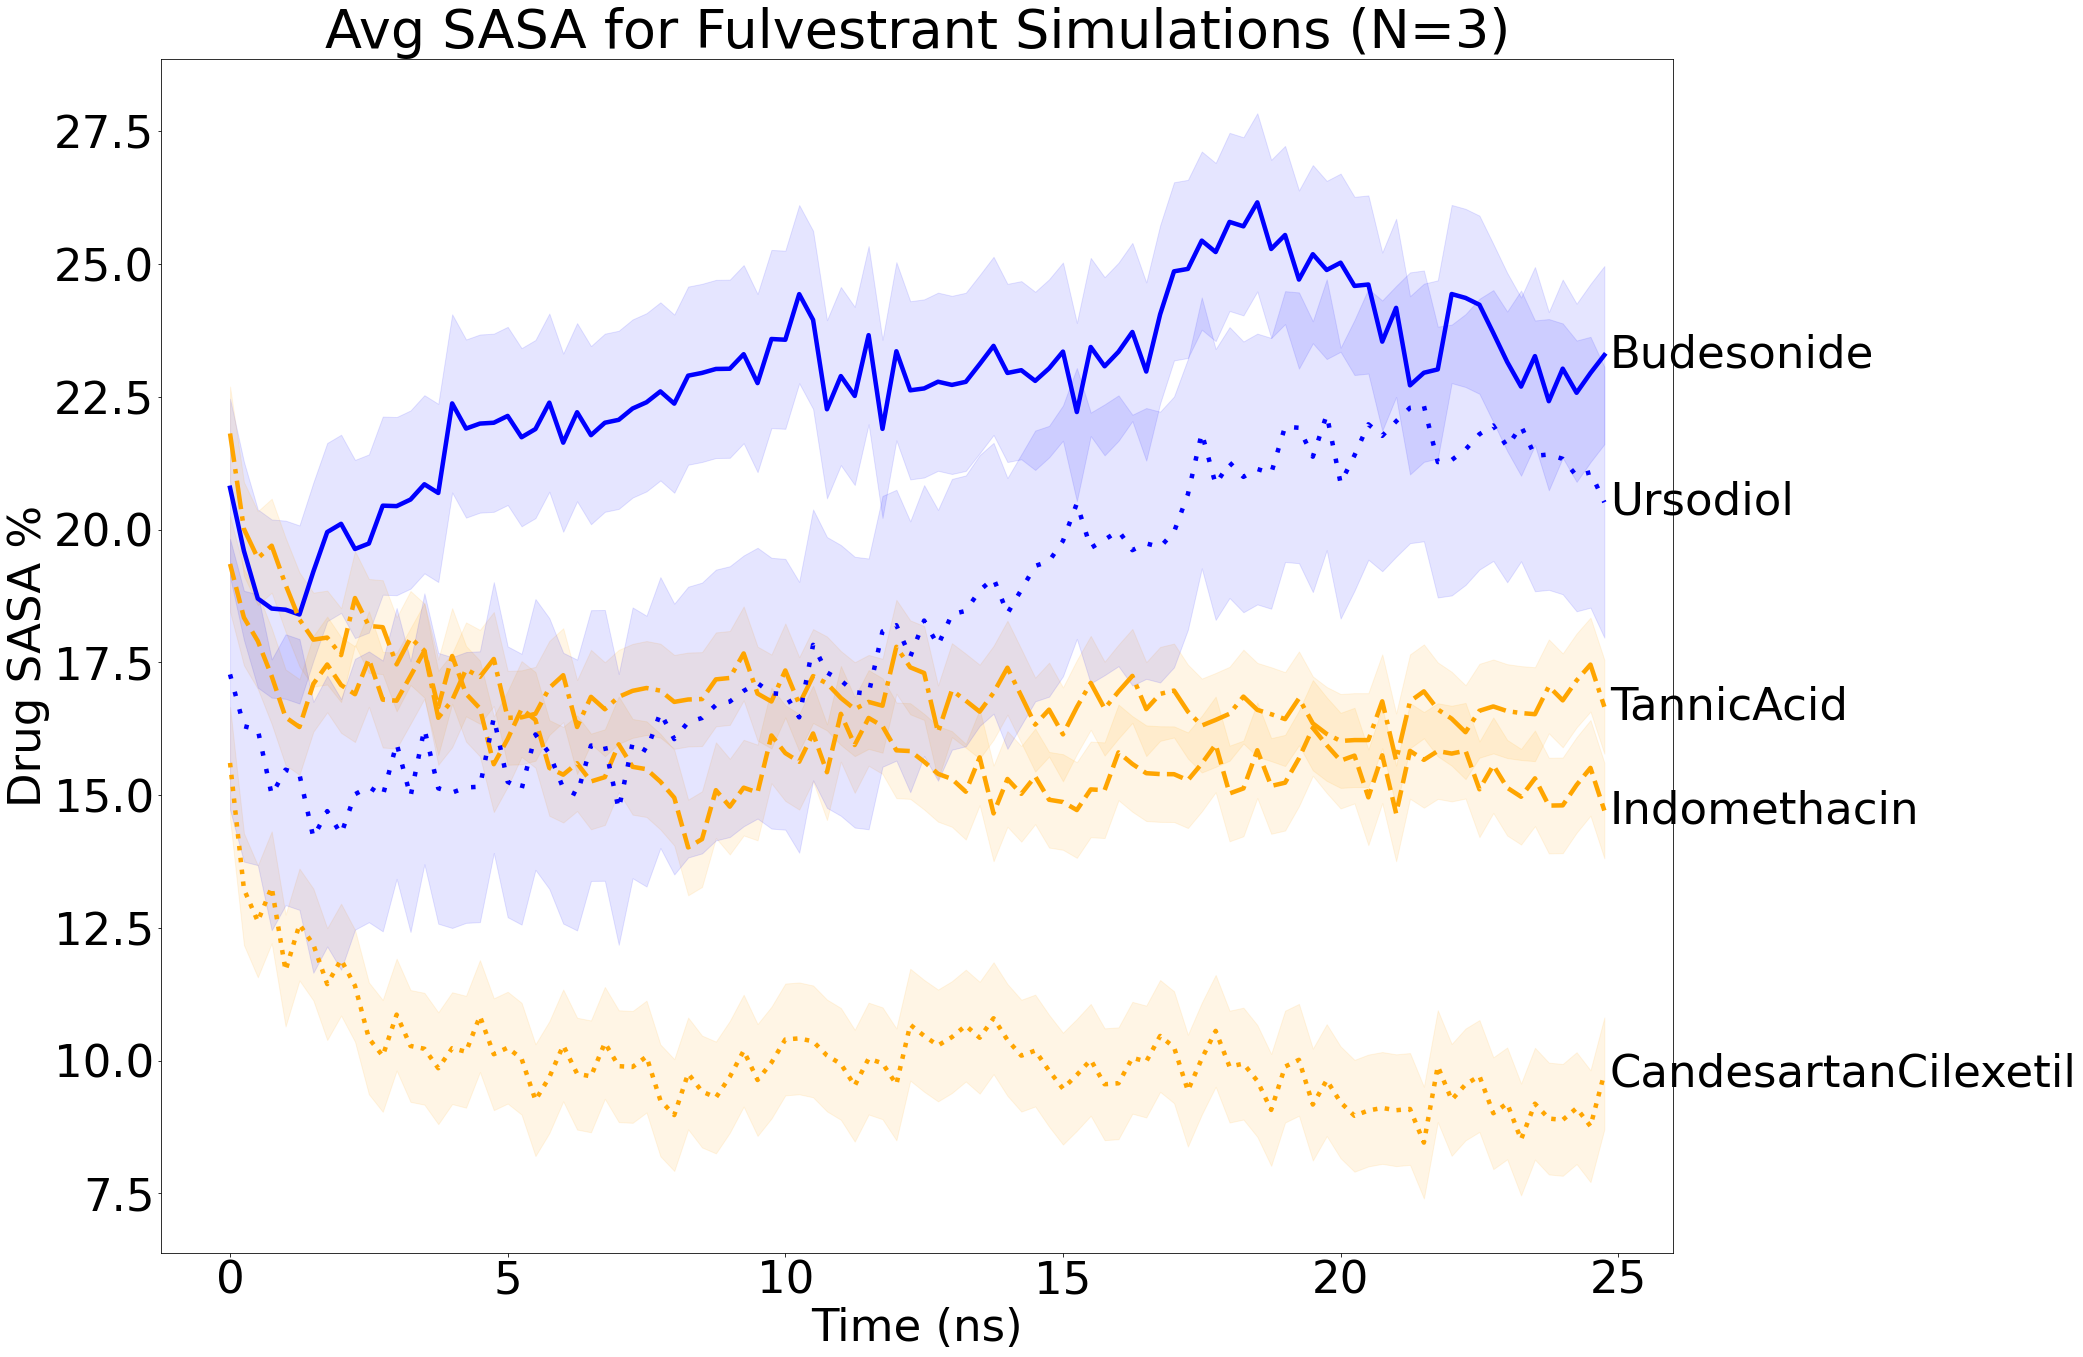

In [48]:
new_fuv_sasa = make_SASAplots(FUV, new_FUV_labels, norms)

### Sorafenib

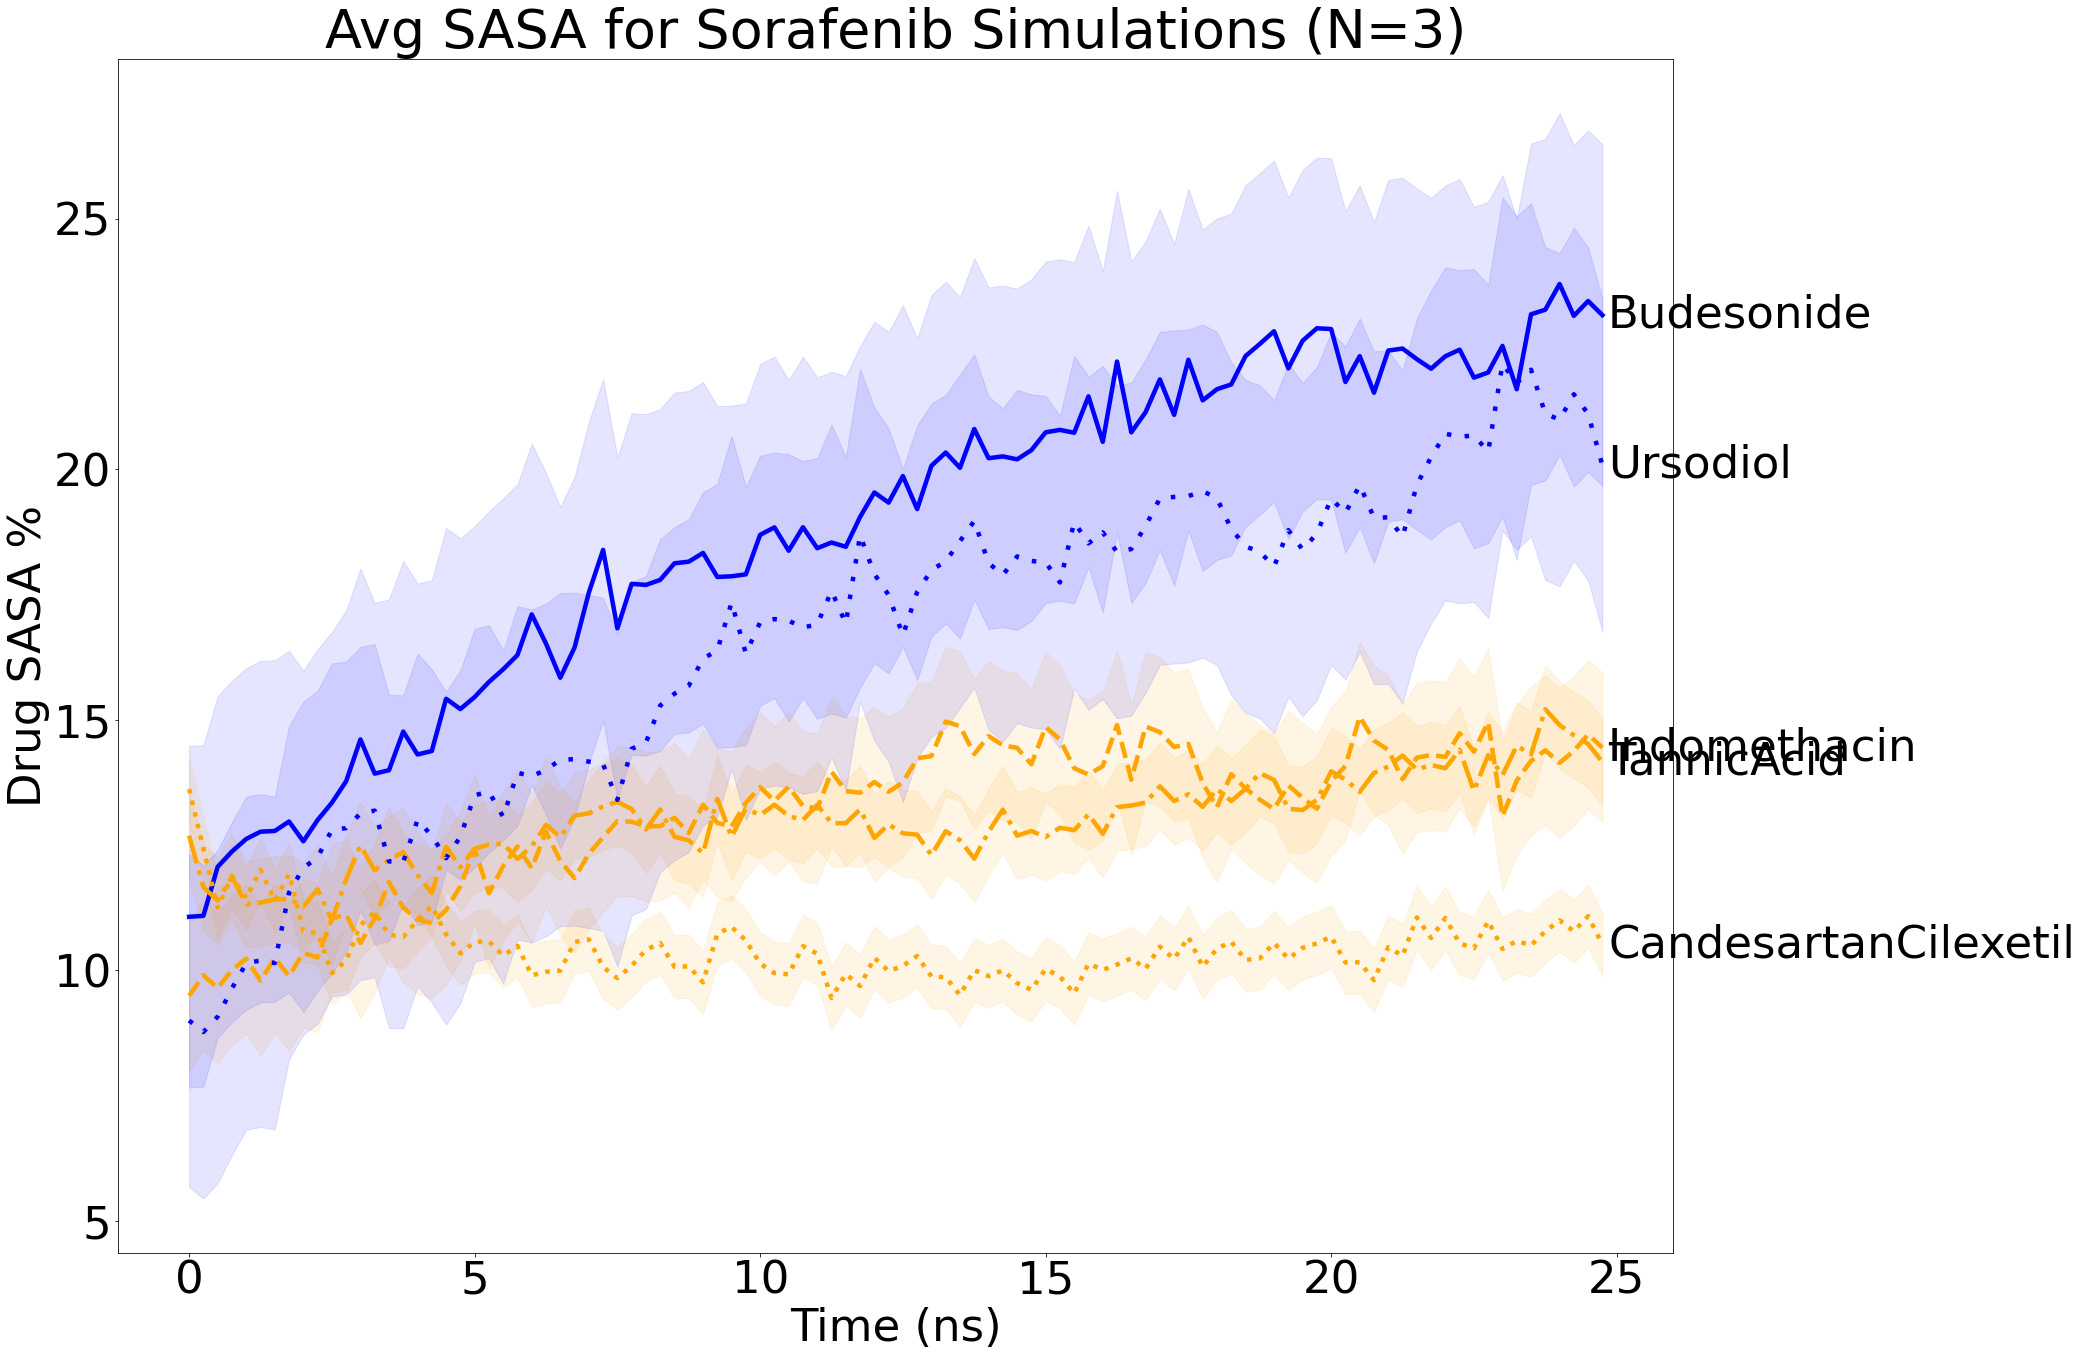

In [49]:
sor_sasa = make_SASAplots(SOR, SOR_labels, norms)

### Lumefantrine

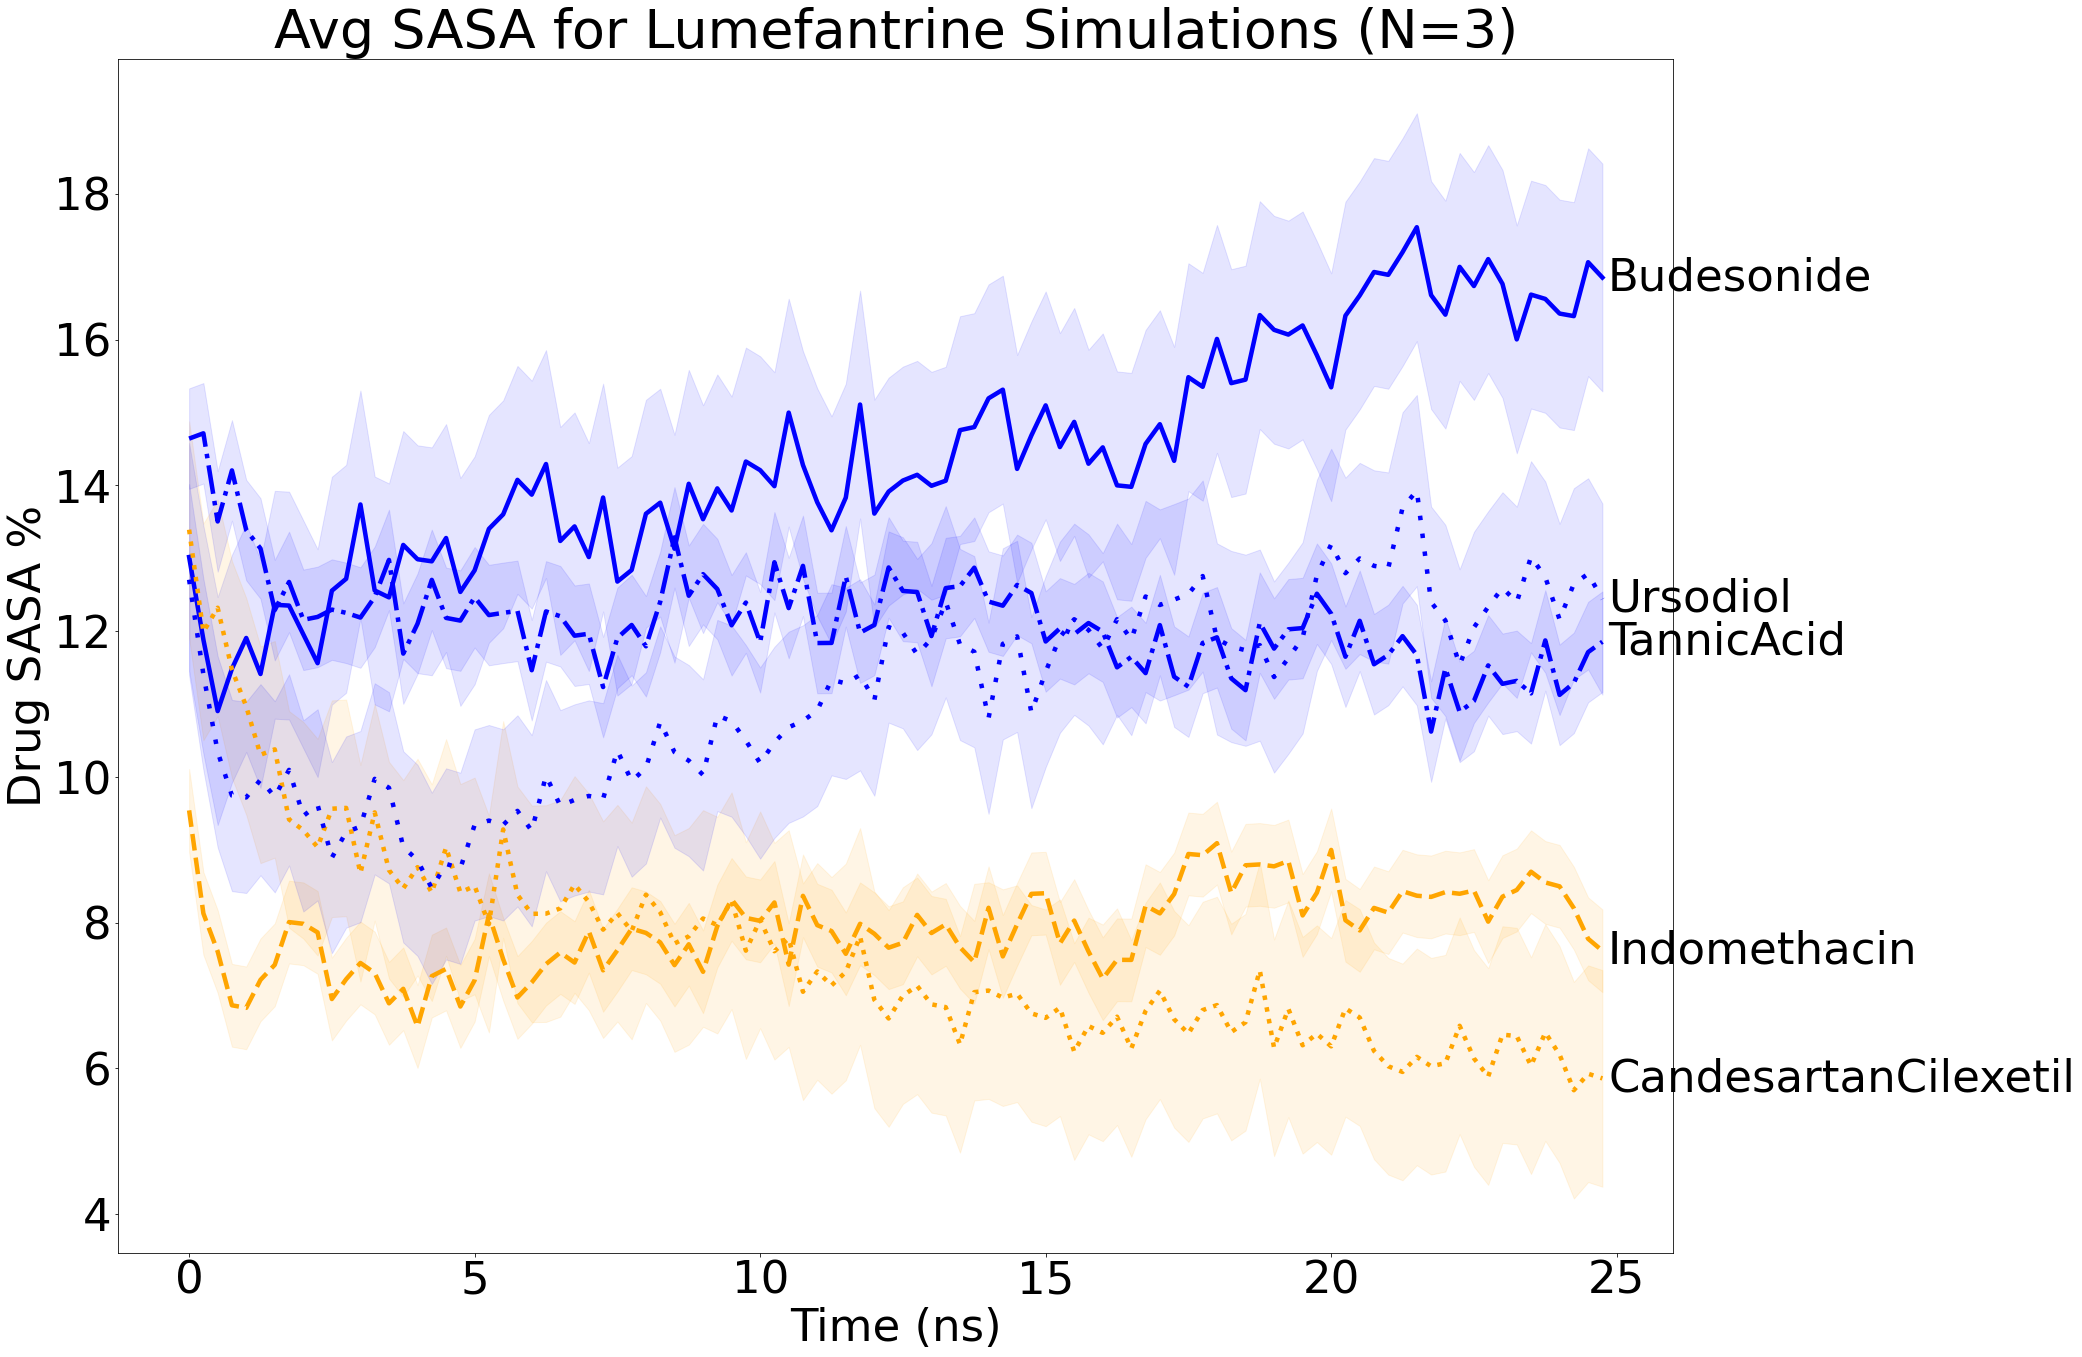

In [50]:
lum_sasa = make_SASAplots(LUM, LUM_labels, norms)

### PTX

In [51]:
make_SASAplots(PTX, PTX_labels, norms)

NameError: name 'PTX' is not defined

### Rilpivirine

In [26]:
RIL[9:12]

['SASA_DATA_openmm_NPT_50ns_PBS-DMSO_jawBreaker_DMSO_Rilpivirine_TannicAcid_100_96_run1.dat',
 'SASA_DATA_openmm_NPT_50ns_PBS-DMSO_jawBreaker_DMSO_Rilpivirine_TannicAcid_100_96_run2.dat',
 'SASA_DATA_openmm_NPT_50ns_PBS-DMSO_jawBreaker_DMSO_Rilpivirine_TannicAcid_100_96_run3.dat']

In [27]:
del RIL[9:12]

In [52]:
RIL

['SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Rilpivirine_Budesonide_100_171_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Rilpivirine_Budesonide_100_171_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Rilpivirine_Budesonide_100_171_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Rilpivirine_CandesartanCilexetil_100_148_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Rilpivirine_CandesartanCilexetil_100_148_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Rilpivirine_CandesartanCilexetil_100_148_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Rilpivirine_Indomethacin_100_205_run1.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Rilpivirine_Indomethacin_100_205_run2.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Rilpivirine_Indomethacin_100_205_run3.dat',
 'SASA_DATA_openmm_NPT_25ns_PBS-DMSO_jawBreaker_DMSO_Rilpivirine_TannicAcid_100_96_run1.dat',
 'SASA_DATA_ope

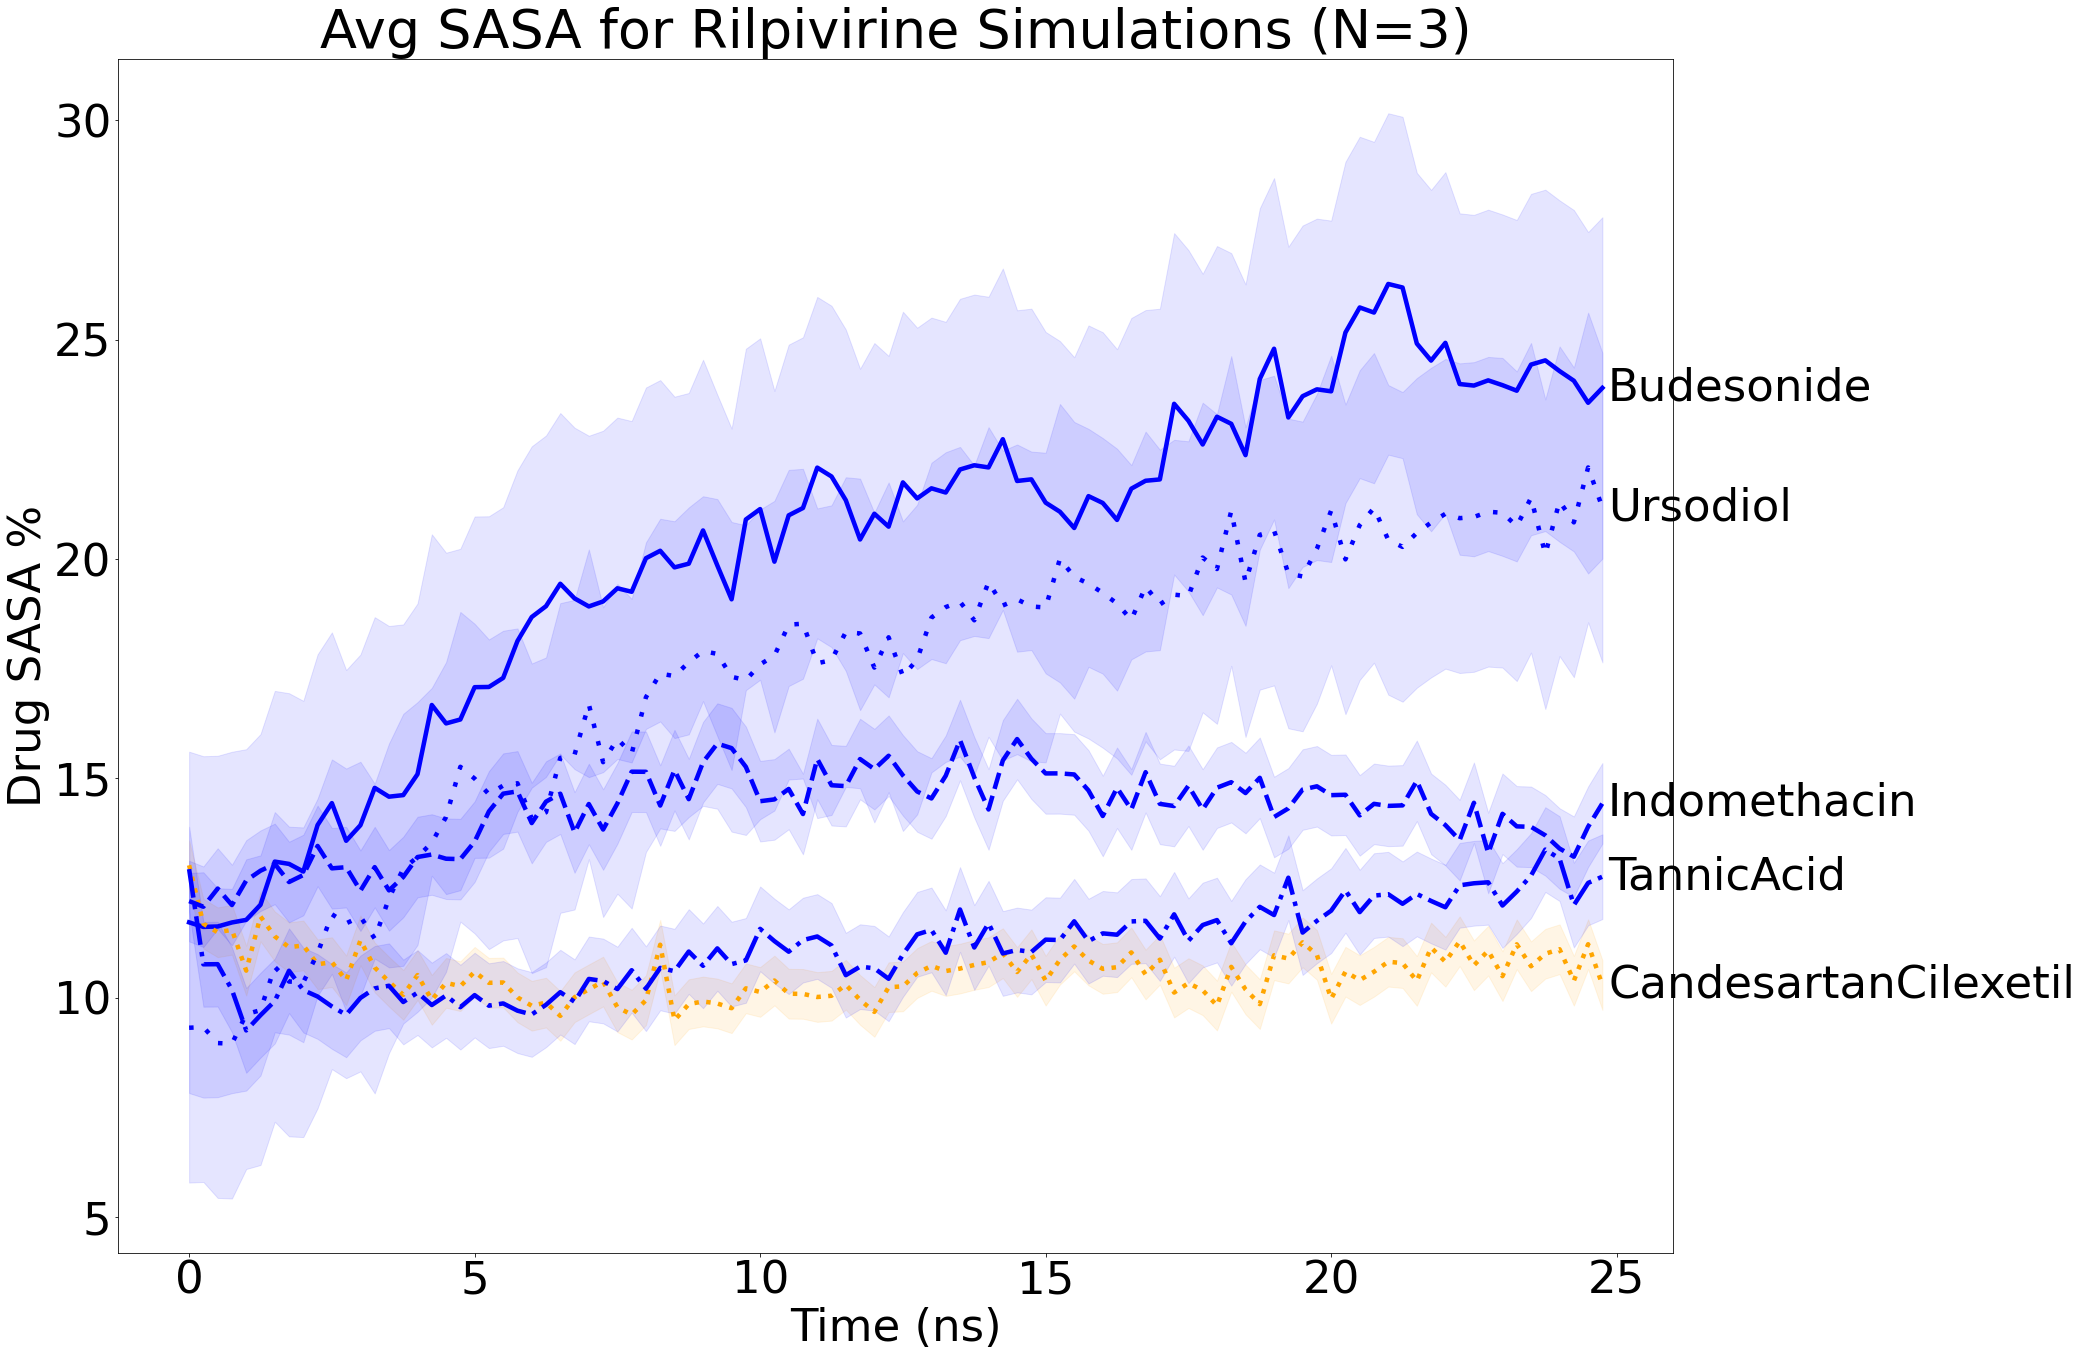

In [53]:
ril_sasa = make_SASAplots(RIL, RIL_labels, norms)

# Spearman R

In [24]:
import sklearn
from sklearn.linear_model import LogisticRegressionCV
from scipy import stats

In [42]:
sasas = [ato_sasa, new_ato_sasa, fuv_sasa, new_fuv_sasa, sor_sasa, lum_sasa, ril_sasa]
labels = [ATO_labels, new_ATO_labels, FUV_labels, new_FUV_labels, SOR_labels, LUM_labels, RIL_labels]
names = ['Atovaquone', 'Atovaquone-Redo', 'Fulvestrant', 'Fulvestrant-Redo', 'Sorafenib', 'Lumefantrine', 'Rilpivirine']

In [31]:
data = pd.DataFrame()
label_frame = pd.DataFrame()
for x in range(len(sasas)):
    X = pd.DataFrame(sasas[x])
    y = pd.DataFrame(labels[x])
    res = stats.spearmanr(X[99], y)
    print(res)
    

SpearmanrResult(correlation=-0.7071067811865475, pvalue=0.18169011381620928)
SpearmanrResult(correlation=0.7071067811865475, pvalue=0.18169011381620928)
SpearmanrResult(correlation=0.5773502691896257, pvalue=0.308068009250357)
SpearmanrResult(correlation=0.8660254037844386, pvalue=0.05766888562243733)
SpearmanrResult(correlation=0.8660254037844386, pvalue=0.05766888562243733)
SpearmanrResult(correlation=0.8660254037844386, pvalue=0.05766888562243733)
SpearmanrResult(correlation=0.7071067811865475, pvalue=0.18169011381620928)


In [45]:
data = pd.DataFrame()
label_frame = pd.DataFrame()
for x in range(len(sasas)):
    X = pd.DataFrame(sasas[x])
    y = pd.DataFrame(labels[x])
    max_corr = -1
    max_p = 0
    best_frame = 0
    for i in range(100):
        res = stats.spearmanr(X[i], y)
        if(res[0] > max_corr):
            max_corr = res[0]
            max_p = res[1]
            best_frame = i
    print(f"\nValues for {names[x]}")
    print(f"Best Corr at frame {best_frame}, or {best_frame*.25}ns simulation time")
    print(f"Best Corr value: {max_corr:.4f}")
    print(f"P Value: {max_p:.4f}")
        


Values for Atovaquone
Best Corr at frame 0, or 0.0ns simulation time
Best Corr value: -0.3536
P Value: 0.5594

Values for Atovaquone-Redo
Best Corr at frame 3, or 0.75ns simulation time
Best Corr value: 0.7071
P Value: 0.1817

Values for Fulvestrant
Best Corr at frame 15, or 3.75ns simulation time
Best Corr value: 0.5774
P Value: 0.3081

Values for Fulvestrant-Redo
Best Corr at frame 38, or 9.5ns simulation time
Best Corr value: 0.8660
P Value: 0.0577

Values for Sorafenib
Best Corr at frame 8, or 2.0ns simulation time
Best Corr value: 0.8660
P Value: 0.0577

Values for Lumefantrine
Best Corr at frame 7, or 1.75ns simulation time
Best Corr value: 0.8660
P Value: 0.0577

Values for Rilpivirine
Best Corr at frame 26, or 6.5ns simulation time
Best Corr value: 0.7071
P Value: 0.1817


All of them

In [143]:
def swap_label(x):
    ret = []
    for i in x:
        if i == '(+)':
            ret.append(1)
        if i == '(-)':
            ret.append(0)
            
    return ret

In [146]:
data = pd.DataFrame()
label_frame = pd.DataFrame()
for x in range(len(sasas)):
    data = data.append(sasas[x], ignore_index=True)
    label_frame = label_frame.append(swap_label(labels[x]), ignore_index = True)
res = stats.spearmanr(data[99], label_frame)
print(res)
print(data)
print(label_frame)

SpearmanrResult(correlation=-0.5836841774546561, pvalue=0.0021911978869255237)
           0          1          2          3          4          5   \
0   14.138645  13.812489  13.412765  14.626134  14.708271  13.665088   
1   12.399243  11.777524  10.883767   9.738739  10.017973   9.406680   
2   11.036086  10.648085  12.047609  10.701616  11.334363  11.062744   
3   15.038043  11.361008  10.660879  11.347672  10.752749  10.377252   
4   10.882335  10.319658   9.735872  10.445486  10.249593  10.756968   
5   20.787516  19.599278  18.701537  18.513270  18.491251  18.401398   
6   15.606208  13.230112  12.623091  13.263513  11.697615  12.562734   
7   19.353481  18.344122  17.901490  17.239705  16.465826  16.282492   
8   21.810407  20.011732  19.461593  19.696926  18.961911  18.308463   
9   17.273174  16.297692  16.231482  15.005599  15.478697  15.388879   
10  11.068738  11.088253  12.066325  12.371418  12.622522  12.767103   
11  13.618343  12.430655  11.252640  11.889265  11.441934

C:\Users\joela\AppData\Local\Temp\ipykernel_10196\801068556.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(sasas[x], ignore_index=True)
C:\Users\joela\AppData\Local\Temp\ipykernel_10196\801068556.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_frame = label_frame.append(swap_label(labels[x]), ignore_index = True)


In [123]:
res = stats.spearmanr(X[99][0:5], y[0:5])

In [124]:
print(res)

SpearmanrResult(correlation=0.7071067811865475, pvalue=0.18169011381620928)
